# Task 3: Try Unet

https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel



Start simple with provided segmentation models from pytorch
https://github.com/qubvel/segmentation_models.pytorch

also https://amaarora.github.io/2020/09/13/unet.html
and https://github.com/amaarora/amaarora.github.io/blob/master/nbs/Training.ipynb

https://www.pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

In [1]:
from task3.utils.utils import init
from task3.utils.config import get_data_loader, get_optimizer, get_model
from task3.utils.data_utils import evaluate
from task3.utils.img_utils import show_img_batch
import importlib
import sys
import time

# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import segmentation_models_pytorch as smp
from torchmetrics import IoU
from torch.nn import BCEWithLogitsLoss

# Image datasets and image manipulation
import torchvision

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

## Params

In [2]:
config = init(config='configs/raphaela.yaml')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


## Define Model

In [4]:
config['model'].get('smp-unet')

{'encoder_name': 'resnet34',
 'encoder_weights': None,
 'in_channels': 1,
 'classes': 1,
 'encoder_depth': 5,
 'decoder_use_batchnorm': True,
 'decoder_channels': [256, 128, 64, 32, 16],
 'decoder_attention_type': None,
 'activation': 'sigmoid',
 'aux_params': None}

In [5]:
model = smp.Unet(**config['model'].get('smp-unet')).to(device)

## Load data

In [6]:
training_loader, validation_loader = get_data_loader(config, mode='train', get_subset=False)
# TODO fix error key
# test_loader = get_data_loader(config, mode='test', get_subset=False)

2021-12-20T06:47:48.860628+0000 DEBUG Exclude samples: None, include samples: None, applied transforms: Compose(
    ToTensor()
)
2021-12-20T06:47:58.406026+0000 DEBUG Loaded samples: ['DY7ASN54S9', 'GC4N2W3CPZ', 'T8KF3Q2B2F', 'DTKPN7XP6M', 'K3AM1YOI38', 'QPQSQTSI7D', 'D29HWPRZUW', 'QFGAOZX5JI', 'RC4B5W3ATB', '8G7XRFIWB3', 'LDBF4IFZ6H', 'AYPVNPO9R0', 'ZSLPMQEWOY', 'FIW33CVMV0', 'IJZFZ2P3UT', '7V9NY3JFPX', 'YTEBHX6SH5', '5NJTVZ6ZOJ', '7IBG80WR2T', 'VVCUF1AI87', 'R5OV0RKYDG', 'YSCCEISFRH', 'MW16WM2HPQ', '1D7PVKV2AP', '8AHY2IWS17', '4XBC2X5ZTR', 'D47OR19ANJ', 'T2LZGPQNQI', 'VI47TJR3OQ', 'GF7SRBBU1E', '2O92K3GBLM', '0S1GBHENTP', 'M1FI0BAOWB', 'O26IJHI6MH', 'IJN60PIITZ', 'XBTT6NEY4T', 'D8I212VOCH', '6I8D4BKPUE', 'IMNKTJV3OI', 'GFOJ0HGKZH', 'YF6QEAWJXY', 'DMKG04F0SB', 'BBB0U709D2', 'C6WKLGHUIM', '3YLPDRY0FA', '4W4P3UREMQ', '11NZLRCO13', 'QZA3WA0E2X', 'R82Q2AL9P7', '1XHV0Q88M5', 'E9AHVWGBUF', 'WO0OOZLXP6', 'ZMJIDN442P', 'OYZFKJR8U3', '3DGDHONGJW', 'YEZ7BPLZW0', 'W00G0Q112W', 'JANFS05F33', 'ON

## Optimizer & Loss

Some optimization algorithms such as Conjugate Gradient and LBFGS need to reevaluate the function multiple times, so you have to pass in a closure that allows them to recompute your model.

https://pytorch.org/docs/stable/optim.html

In [7]:
# use config file
# get_model(config)
# optimizer = get_optimizer(model, config)
# criterion = get_loss(config)

In [8]:
#optimizer = config['training']['optimizer']
#lr = config['training']['lr']
#momentum = config['training']['momentum']
#loss = config['training']['loss']
#num_classes = config['training'].get('get_classes', 2)
#
#if optimizer == 'Adam':
#    
#elif optimizer == 'SGD':
#    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
#else:
#    raise Exception('Optimizer not supported, choose among Adam and SGD.')
#
##if loss == 'iou':
#    criterion = IoU(num_classes=num_classes)
#
#elif loss == 'bcewithlogits':
#    assert config['model']['smp-unet']['activation'] == None, f'Last layer of the Unet model should not be sigmoid \
#    if you are using {loss}.'
#    # Sigmoid + BCELoss, numerically more stable 
#    criterion = BCEWithLogitsLoss(pos_weight=None) 
#

optimizer = optim.Adam(model.parameters(), lr=0.0005)
#criterion = smp.utils.losses.DiceLoss()
criterion = smp.utils.losses.JaccardLoss()
#criterion = BCEWithLogitsLoss()
metrics = [
    smp.utils.metrics.IoU(activation=None), # https://github.com/qubvel/segmentation_models.pytorch/issues/17
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.IoU(threshold=0.0),
    smp.utils.metrics.IoU(threshold=0.0, activation=None),
    
]
# initialize metric
num_classes = config['training'].get('get_classes', 1) 
metric = IoU(num_classes=num_classes+1) # num classes in Unet=1 for binary segmentation, corresponds to two in IoU score

## Show images on Tensorboard

In [9]:
writer = SummaryWriter('runs/mitrial_valve_training_2')

In [10]:

# get some random training images
dataiter = iter(training_loader)
images, labels = dataiter.next()

# create grid of images
fimg_grid = torchvision.utils.make_grid(images)
limg_grid = torchvision.utils.make_grid(labels)


# write to tensorboard
writer.add_image('mv_batch_1_frames', fimg_grid)
writer.add_image('mv_batch_1_labels', limg_grid)

## Training loop

In [11]:
print(len(validation_loader))

for epoch in range(config['training'].get('epochs', 1)):  # loop over the dataset multiple times
    running_loss = 0.0
    running_score = 0.0

    for i, batch in enumerate(training_loader, 0):
        # basic training loop
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        iou_train = metric(outputs, labels)
        #print(f"IoU training score on batch {i}: {iou_train}")
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_score += iou_train.item()
        if i % 2 == 0:    # Every second mini-batch...
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0
            running_vscore = 0.0

            model.train(False) # Don't need to track gradents for validation
            for j, vdata in enumerate(validation_loader):
                vinputs, vlabels = vdata
                voutputs = model(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
                iou_val = metric(voutputs, vlabels)
                running_vscore += iou_val.item()
                #print(f'Loss validation on batch {j}: {vloss}')
                #print(f"IoU validation score on batch {j}: {iou_val}")

            model.train(True) # Turn gradients back on for training

            avg_loss = running_loss / 2
            avg_vloss = running_vloss / len(validation_loader)
            
            avg_iou = running_score / 2
            avg_viou = running_vscore / len(validation_loader)

            # Log the running loss averaged per batch
            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(training_loader) + i)
            writer.add_scalars('Training vs. Validation Score IoU',
                            { 'Training' : avg_iou, 'Validation' : avg_viou },
                            epoch * len(training_loader) + i)

            running_loss = 0.0
            running_score = 0.0
print('Finished Training')

writer.flush()

13
Batch 1
Batch 3
Batch 5
Batch 7
Batch 9
Batch 11
Batch 13
Batch 15
Batch 17
Batch 19
Batch 21
Batch 23
Batch 25
Batch 27
Batch 29
Batch 31
Batch 33
Batch 35
Batch 37
Batch 39
Batch 41
Batch 43
Batch 45
Batch 47
Batch 49
Batch 51
Batch 1
Batch 3
Batch 5
Batch 7
Batch 9
Batch 11
Batch 13
Batch 15
Batch 17
Batch 19
Batch 21
Batch 23
Batch 25
Batch 27
Batch 29
Batch 31
Batch 33
Batch 35
Batch 37
Batch 39
Batch 41
Batch 43
Batch 45
Batch 47
Batch 49
Batch 51
Batch 1
Batch 3
Batch 5
Batch 7
Batch 9
Batch 11
Batch 13
Batch 15
Batch 17
Batch 19
Batch 21
Batch 23
Batch 25
Batch 27
Batch 29
Batch 31
Batch 33
Batch 35
Batch 37
Batch 39
Batch 41
Batch 43
Batch 45
Batch 47
Batch 49
Batch 51
Batch 1
Batch 3
Batch 5
Batch 7
Batch 9
Batch 11
Batch 13
Batch 15
Batch 17
Batch 19
Batch 21
Batch 23
Batch 25
Batch 27
Batch 29
Batch 31
Batch 33
Batch 35
Batch 37
Batch 39
Batch 41
Batch 43
Batch 45
Batch 47
Batch 49
Batch 51
Batch 1
Batch 3
Batch 5
Batch 7
Batch 9
Batch 11
Batch 13
Batch 15
Batch 17
Batch

Batch 41
Batch 43
Batch 45
Batch 47
Batch 49
Batch 51
Batch 1
Batch 3
Batch 5
Batch 7
Batch 9
Batch 11
Batch 13
Batch 15
Batch 17
Batch 19
Batch 21
Batch 23
Batch 25
Batch 27
Batch 29
Batch 31
Batch 33
Batch 35
Batch 37
Batch 39
Batch 41
Batch 43
Batch 45
Batch 47
Batch 49
Batch 51
Batch 1
Batch 3
Batch 5
Batch 7
Batch 9
Batch 11
Batch 13
Batch 15
Batch 17
Batch 19
Batch 21
Batch 23
Batch 25
Batch 27
Batch 29
Batch 31
Batch 33
Batch 35
Batch 37
Batch 39
Batch 41
Batch 43
Batch 45
Batch 47
Batch 49
Batch 51
Batch 1
Batch 3
Batch 5
Batch 7
Batch 9
Batch 11
Batch 13
Batch 15
Batch 17
Batch 19
Batch 21
Batch 23
Batch 25
Batch 27
Batch 29
Batch 31
Batch 33
Batch 35
Batch 37
Batch 39
Batch 41
Batch 43
Batch 45
Batch 47
Batch 49
Batch 51
Batch 1
Batch 3
Batch 5
Batch 7
Batch 9
Batch 11
Batch 13
Batch 15
Batch 17
Batch 19
Batch 21
Batch 23
Batch 25
Batch 27
Batch 29
Batch 31
Batch 33
Batch 35
Batch 37
Batch 39
Batch 41
Batch 43
Batch 45
Batch 47
Batch 49
Batch 51
Finished Training


## Visualizing your model

In [12]:
writer.add_graph(model, images)
writer.close()

## Training loop SMP

In [13]:
print('Trying second training loop (SMP)')



# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(training_loader)
    valid_logs = valid_epoch.run(validation_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

Trying second training loop (SMP)

Epoch: 0
valid: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.32it/s, jaccard_loss - 0.3858, iou_score - 0.3534]
Model saved!

Epoch: 1
valid: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.45it/s, jaccard_loss - 0.414, iou_score - 0.3394]

Epoch: 2
valid: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.08it/s, jaccard_loss - 0.4033, iou_score - 0.3447]

Epoch: 3
valid: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.16it/s, jaccard_loss - 0.3863, iou_score - 0.3532]

Epoch: 4
valid: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.13it/s, jaccard_loss - 0.4009, iou_score - 0.3461]

Epoch: 5
valid: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:03

valid: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.15it/s, jaccard_loss - 0.4167, iou_score - 0.3379]

Epoch: 25
valid: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.20it/s, jaccard_loss - 0.4033, iou_score - 0.3448]
Decrease decoder learning rate to 1e-5!

Epoch: 26
valid: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.04it/s, jaccard_loss - 0.3962, iou_score - 0.3483]

Epoch: 27
valid: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.53it/s, jaccard_loss - 0.3932, iou_score - 0.3497]

Epoch: 28
valid: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.27it/s, jaccard_loss - 0.3929, iou_score - 0.3499]

Epoch: 29
valid: 100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.69

In [14]:
best_model = torch.load('./best_model.pth')

In [27]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [34]:
labels_pred = (labels_pred.cpu().numpy().round())

In [39]:
labels_pred.shape

torch.Size([3, 2, 256, 256])

In [38]:
batch = next(iter(validation_loader))
frames_valid, labels_truth = batch
#show_img_batch(frames_t, labels_t)

#gt_mask = gt_mask.squeeze()

x_tensor = frames_valid.to(device)
labels_pred = best_model.predict(x_tensor)
#labels_pred = (labels_pred.cpu().numpy().round())

#visualize(
#    image=frames_valid, 
#    ground_truth_mask=labels_truth, 
#    predicted_mask=labels_pred
#)
#   

#show_img_batch(frames_valid, labels_pred)

In [17]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

torch.Size([3, 256, 256])


/home/hoga/eth/aml/aml-project/task3/utils/img_utils.py:128: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  list_images = np.array(list_images)
/home/hoga/eth/aml/aml-project/task3/utils/img_utils.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  list_images = np.array(list_images)


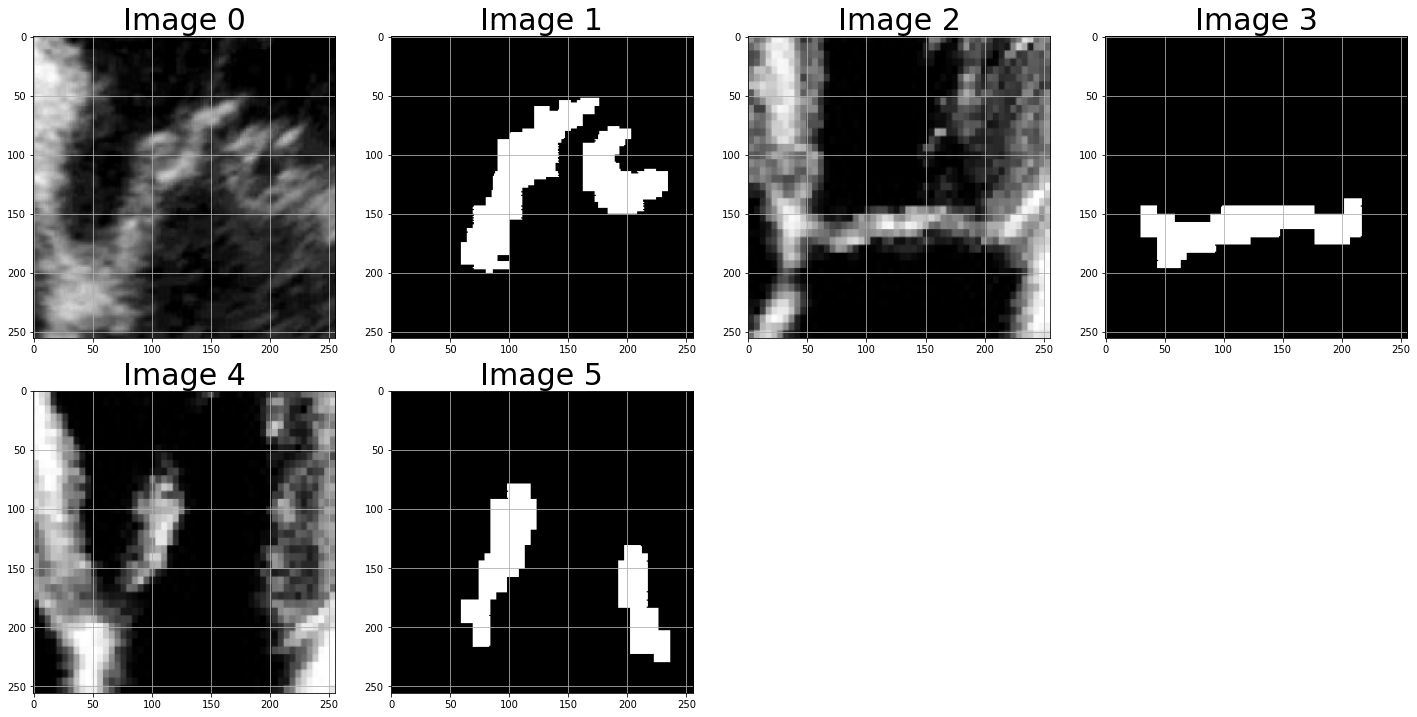

In [25]:
# ground truth
show_img_batch(frames_t, labels_t)

In [ ]:
class Block(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, output_channels, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(output_channels, output_channels, 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [ ]:

#
#from engine import train_one_epoch, evaluate
#import utils
#
#
#def main():
#    # train on the GPU or on the CPU, if a GPU is not available
#    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#
#    # our dataset has two classes only - background and person
#    num_classes = 2
#    # use our dataset and defined transformations
#    dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
#    dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))
#
#    # split the dataset in train and test set
#    indices = torch.randperm(len(dataset)).tolist()
#    dataset = torch.utils.data.Subset(dataset, indices[:-50])
#    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
#
#    # define training and validation data loaders
#    data_loader = torch.utils.data.DataLoader(
#        dataset, batch_size=2, shuffle=True, num_workers=4,
#        collate_fn=utils.collate_fn)
#
#    data_loader_test = torch.utils.data.DataLoader(
#        dataset_test, batch_size=1, shuffle=False, num_workers=4,
#        collate_fn=utils.collate_fn)
#
#    # get the model using our helper function
#    model = get_model_instance_segmentation(num_classes)
#
#    # move model to the right device
#    model.to(device)
#
#    # construct an optimizer
#    params = [p for p in model.parameters() if p.requires_grad]
#    optimizer = torch.optim.SGD(params, lr=0.005,
#                                momentum=0.9, weight_decay=0.0005)
#    # and a learning rate scheduler
#    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                   step_size=3,
#                                                   gamma=0.1)
#
#    # let's train it for 10 epochs
#    num_epochs = 10
#
#    for epoch in range(num_epochs):
#        # train for one epoch, printing every 10 iterations
#        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
#        # update the learning rate
#        lr_scheduler.step()
#        # evaluate on the test dataset
#        evaluate(model, data_loader_test, device=device)
#
#    print("That's it!")